In [81]:
import cv2
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Activation, Dropout, BatchNormalization, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical, plot_model

from pathlib import Path

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [82]:
image_path = "C:\\Users\\vielm\\pokemon\\dataset\\Charmander\\00000000.png"

In [83]:
img = image.load_img(image_path, target_size=(96,96))
#plt.imshow(img)

In [84]:
#image.img_to_array(img) / 255

In [85]:
p = Path("C:\\Users\\vielm\\pokemon\\dataset")
dirs = p.glob('*')

labels = []
data = []

for folder_dir in dirs:
    label = str(folder_dir).split('\\')[-1]
    #labels.append(label)
    if label == "Charmander" or label == "Bulbasaur" or label == "Pikachu"  or label == "Squirtle" or label == "Mew":
        for img_path in folder_dir.glob('*.[jpg][png][jpeg]'):
            labels.append(label)
            tmp_img = image.load_img(img_path, target_size=(96,96))
            tmp_img_array = image.img_to_array(tmp_img)
            data.append(tmp_img_array)
            #print(img_path)
print(len(labels))
print(len(data))

1223
1223


In [86]:
class_names  = list(dict.fromkeys(labels))
print(class_names)

['Bulbasaur', 'Charmander', 'Mew', 'Pikachu', 'Squirtle']


In [87]:
data = np.array(data, dtype="float") / 255
labels = np.array(labels) 
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print(labels_encoded)
print(len(labels_encoded))
print(len(data))

[0 0 0 ... 4 4 4]
1223
1223


In [88]:
#dictionary = dict(zip(labels, vec))
#print(dictionary)

In [89]:
#(trainX, testX, trainY, testY) = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)
shuffledX, shuffledY = shuffle(data, labels_encoded)
trainX, valX, testX = np.split(shuffledX, [int(0.6*len(data)),int(0.8*len(data))])
trainY, valY, testY = np.split(shuffledY, [int(0.6*len(data)),int(0.8*len(data))])
trainX = np.array(trainX)
testX = np.array(testX)
trainY = np.array(trainY)
testY = np.array(testY)

In [90]:
print(len(trainX))
print(len(valX))
print(len(testX))

733
245
245


3
(733, 96, 96, 3)


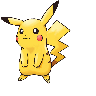

In [91]:
print(trainY[0])
print(trainX.shape)
image.array_to_img(trainX[0] * 255)

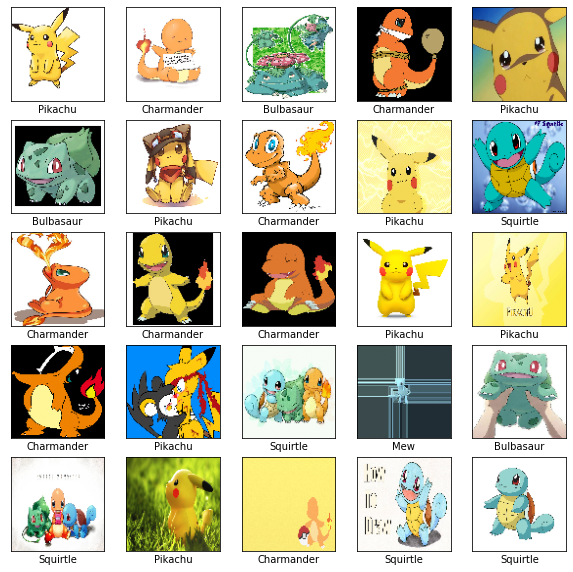

In [92]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainX[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[trainY[i]])
plt.show()

In [93]:
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))
    # return the constructed network architecture
    return model

In [94]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 30
IMAGE_DIMS = (96, 96, 3)

In [133]:
datagen = image.ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [134]:
#print(len(trainX))
#train_generator = datagen.flow(trainX, trainY_categorical, batch_size=BS, subset='training')
#print(len(train_generator))
#val_generator =  datagen.flow(trainX, trainY_categorical, batch_size=BS, subset='validation')
#print(len(val_generator))

In [135]:
model = build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],depth=IMAGE_DIMS[2], classes=len(class_names))
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [136]:
trainY_categorical = to_categorical(trainY, len(class_names))
testY_categorical = to_categorical(testY, len(class_names))
valY_categorical = to_categorical(valY, len(class_names))
print(trainY_categorical.shape)
print(trainX.shape)
print(len(labels_encoded))

(733, 5)
(733, 96, 96, 3)
1223


In [137]:
print(len(trainX) * 0.8 // BS)

19.0


In [138]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15)
checkpoint_filepath = './tmp/checkpoint'
mc = ModelCheckpoint(checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [139]:
H = model.fit(x=datagen.flow(trainX, trainY_categorical, batch_size=BS), 
              validation_data= (valX, valY_categorical),
              steps_per_epoch=len(trainX) // BS, 
              validation_steps = len(valX) // BS,   
              epochs=EPOCHS,
              callbacks=[es,mc],
              verbose=1)

Epoch 1/100
24/24 [==============================] - 3s 99ms/step - loss: 1.4521 - accuracy: 0.6188 - val_loss: 1.6637 - val_accuracy: 0.2735
Epoch 2/100
24/24 [==============================] - 2s 69ms/step - loss: 1.0493 - accuracy: 0.7383 - val_loss: 2.8649 - val_accuracy: 0.2204
Epoch 3/100
24/24 [==============================] - 2s 70ms/step - loss: 0.7171 - accuracy: 0.7895 - val_loss: 3.2154 - val_accuracy: 0.2449
Epoch 4/100
24/24 [==============================] - 2s 74ms/step - loss: 0.6378 - accuracy: 0.8108 - val_loss: 3.0406 - val_accuracy: 0.3673
Epoch 5/100
24/24 [==============================] - 2s 74ms/step - loss: 0.7818 - accuracy: 0.7781 - val_loss: 3.7412 - val_accuracy: 0.2490
Epoch 6/100
24/24 [==============================] - 2s 73ms/step - loss: 0.5824 - accuracy: 0.8122 - val_loss: 4.0380 - val_accuracy: 0.3020
Epoch 7/100
24/24 [==============================] - 2s 72ms/step - loss: 0.4512 - accuracy: 0.8691 - val_loss: 3.9049 - val_accuracy: 0.3959
Epoch 

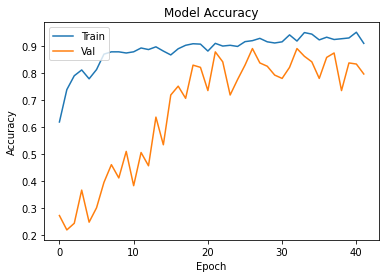

In [140]:
"""Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

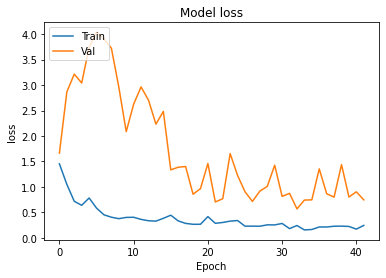

In [141]:
"""Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("Model loss")
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [142]:
_, acc = model.evaluate(testX, testY_categorical, batch_size=BS)
print("\nPrueba del Accuracy en Test sample: %.1f%%" % (100.0 * acc))

9/9 [==============================] - 0s 32ms/step - loss: 0.9225 - accuracy: 0.8000

Prueba del Accuracy en Test sample: 80.0%
